In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import sys

sys.path.append("../../modules")
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "workspace"
model_name = "2D_trans"
exe_name="../../exe/mf6"

In [3]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../data/MNT/MNT_50.tif"
MNT20_path = "../../data/MNT/MNT_20.tif"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

In [4]:
#spatial parameters

# get x0,y0,y1 and x1 from the DEM
x0,y0,x1,y1 = get_MNTbbox(MNT_path)
x1 += 1000

Lx = x1-x0
Ly = y1-y0
nlay = 1
res = 300
ncol = int(Lx/res)
nrow = int(Ly/res)
delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

idomain = np.zeros((nrow*ncol))

In [5]:
#temporal parameters

perioddata=[[1.0,1,1.]] # list containing every period data
nper = 24
perlen = 86400*30
nstep = 5
for i in range(nper-1):
    perioddata.append([perlen,nstep,1])

In [6]:
MNT = Raster.load(MNT_path)

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                 # to pre-process data

top = MNT.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = MNT.bands[0],
                                method="nearest")

In [7]:
## Gridgen object to speed up the code

# create fakesimulation
sim_f = fp.mf6.MFSimulation(sim_name='fake_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)

# create gwf model
gwf_f = fp.mf6.ModflowGwf(sim_f, modelname="model_name",
                           model_nam_file='{}.nam'.format(model_name))

dis_f = fp.mf6.ModflowGwfdis(gwf_f,nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,xorigin=x0,yorigin=y0)

g = Gridgen(dis_f,exe_name="../../exe/Gridgen.exe")
g.build()

In [8]:
# load botom based on the differents surfaces
folder_path = "../../data/txt_couches_nouv"
surfaces = []
for file in glob.glob(os.path.join(folder_path, '*.txt')):
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]
BOT = PMS.copy()
BOT[PMS==-9999] = PC[PMS==-9999]
BOT[PC==-9999] = Q[PC==-9999]
BOT[BOT==-9999] = top[BOT==-9999] - 50

BOT[(top-BOT)<=10] = top[(top-BOT)<=10] - 10 # minimum of 10 m thickness to avoid bug and numerical issues

In [9]:
domain_path = "../../data/shp/limiteModeleRoussillon_poly"
shp2idomain(domain_path,g,idomain)

# Do a list of all active cells
idomain = idomain.reshape(nlay,nrow,ncol)
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))
idomain = idomain.reshape(nlay*nrow*ncol)

In [10]:
# recharge areas
path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(path,grid)

In [11]:
# coeff rch months
# coeff based on Perpignan's Precipitations 
P = np.array([50,45,43.5,56,50,28.3,17.1,32,47.3,90,59,54.4]) # P by month
coeff = 12*P/P.sum()

# Transient recharge
fac = 1/(1000*365*86400) # transfo from mm/y to m/s
dic_rch = {}
dic_rch[0] = rcha*fac # init the recharge for the steady period

icoff = 0
for iper in range(nper-1): # loop for others periods (transient)
    if icoff > 11:
        icoff = 0
    dic_rch[iper+1] = rcha*coeff[icoff]*fac
    icoff+=1

In [12]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [13]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))
    lst_chd.append(x)

In [14]:
# BC rivers
Agy_chd = Complete_riv(Agly_path,"../../data/Fleuves/stations_agly.csv",us=28,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,"../../data/Fleuves/stations_tet2.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,"../../data/Fleuves/stations_bol.csv",us=180,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,"../../data/Fleuves/stations_reart.csv",us=130,ds=0,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,"../../data/Fleuves/stations_cant.csv",us=135,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,"../../data/Fleuves/stations_tech.csv",us=170,ds=0.1,lst_chd=lst_chd,
                       lst_domain=lst_domain,grid=grid)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [15]:
# Variations in rivers
# not finished yet
def trans_riv(riv_chd,nper):
    dic_riv={} # all the data
    riv_spd=[] # data for a given period
    var_riv = [0.2,0.2,0.1,0,-0.1,-0.2,-0.3,-0.3,-0.1,0.2,0.1,0.1] # stage's variations for each month (jan,feb,...)

    im = 0 # index for months
    dic_riv[0] = riv_chd # 1st period is steady, use default values
    for iper in range(nper-1): # loop to calculate stage for each period
        if im > 11:
            im = 0
        for icell,chd in riv_chd:
            riv_spd.append((icell,chd+var_riv[im]))

        dic_riv[iper+1] = riv_spd
        riv_spd=[]
        im +=1
    return dic_riv

In [16]:
var_riv = [0.2,0.2,0.1,0,-0.1,-0.2,-0.3,-0.3,-0.1,0.2,0.1,0.1] # stage's variations for each month (jan,feb,...)
lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]

In [17]:
# permeability

# initialize arrays that will define the position of the formations
idomainQ_rec = np.zeros([nrow*ncol])
idomainQ_a = np.zeros([nrow*ncol])
idomainPlio = np.zeros([nrow*ncol])

pathQr = "../../data/shp/entités/Alluv_rec" # shapefile of the Quaternary formations
pathQa = "../../data/shp/entités/Alluv_anc.shp" #...
pathP = "../../data/shp/entités/Pliocene"
shp2idomain(pathQr,g,idomainQ_rec)
#shp2idomain(pathQa,g,idomainQ_a) # doesn't work...
lstIDQ_anc = gp2idomain(gp.read_file(pathQa),grid,idomainQ_a,area=10) 
shp2idomain(pathP,g,idomainPlio)


C:\Users\emmal\Anaconda3\lib\site-packages\flopy\utils\gridgen.py:1552: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  usecols=tuple(range(ncol)))


In [18]:
# define k, different for each lithology
kh = 1e-4 # general k
kQr = 4e-5 # k for recent Quaternary
kQa = 2.6e-5 # k for ancient Quaternary
kp = 1e-5 # k for pliocene

k = np.ones([nrow*ncol])*kh # vector containing the permeability array(layer,nrow,ncol)
k[idomainPlio==1] = kp
k[idomainQ_rec==1] = kQr
k[idomainQ_a==1] = kQa

In [19]:
def trans_wel(wel_spd,nper,coeff):
    dic_wel={} # all the data
    wel_p =[] # data for a given period

    im = 0 # index for months
    dic_wel[0] = wel_spd # 1st period is steady, use default values
    for iper in range(nper-1): # loop to calculate stage for each period
        if im > 11:
            im = 0
        for icell,Q in wel_spd:
            wel_p.append((icell,Q*coeff[im]))

        dic_wel[iper+1] = wel_p
        wel_p=[]
        im +=1
    return dic_wel

In [20]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"
V_col = "V_A_AEMRC"
layer = 0
stress_data_well = importWells(path,grid,lst_domain,V_col=V_col,layer=layer)

In [21]:
Q_rate_m = np.array([5836,6509,6509,8678,10354,15530,18660,18660,8202,5836,5836,5836]) # values of uptaking from Chabart (Quat layer)
Q_rate_y = 9704
coeff = Q_rate_m/Q_rate_y

dic_wel = trans_wel(stress_data_well,nper,coeff)

In [22]:
BOT-= 10

In [34]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first2D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=BOT,xorigin=x0,yorigin=y0,idomain=idomain)

### tdis
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=perioddata,nper=nper)

#solver
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='moderate')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=BOT+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST')
                                       ,("BUDGET","LAST")
                                       ],
                            printrecord=[('BUDGET', 'LAST')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k, save_flows=True,save_specific_discharge=True)


# storage package
sy = 0.01
ss = 1e-5
sto = fp.mf6.ModflowGwfsto(gwf, pname='sto', save_flows=False, iconvert=1, 
                              ss=ss, sy=sy, steady_state={0:True},
                              transient={1:True}) 

# well package
wel = fp.mf6.ModflowGwfwel(gwf, pname="wel",filename="wel.wel",
                           stress_period_data=dic_wel, maxbound=len(stress_data_well))

# recharge
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = dic_rch)
   
# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [35]:
# observation --> {filename:[("observation name","type of observation",(cellid)),
#                            ("observation name2","flux observation",(cellid2n),(cellid2m))]
#                  filename2:[(observation name3,"type of observation3,(cellid3)")]}

# Head points to observe
lst_pts = [(0,75,75),(0,90,80),(0,110,90)]
obs_lst1=[]
for pts in lst_pts:
    obs_lst1.append((("ROW: {}/COL: {}".format(pts[1],pts[2]),"HEAD",pts)))
    
    
obs_recarray = {'head_obs.csv':obs_lst1}
obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

In [36]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 2D_trans...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package wel...
    writing package rcha...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
    writing package head_obs...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geol

(True, [])

## Vizu

In [37]:
hds = get_heads(model_name,model_dir,obj=True) # get head object

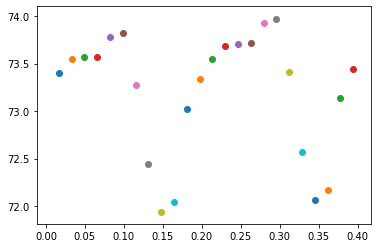

In [38]:
i=0
for it in hds.get_kstpkper():
    head2 = hds.get_data(kstpkper=it)
    i+=1*(30/nstep)
    plt.scatter(i/365,head2[0,105,75])

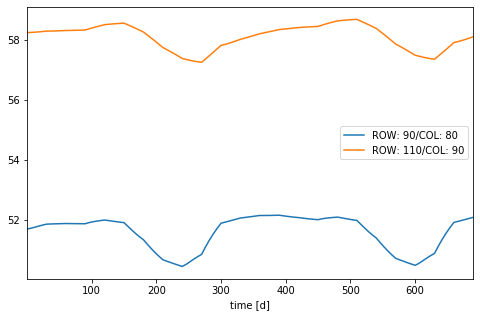

In [28]:
fig,ax = plt.subplots(figsize=(8,5))
path_obs=os.path.join(model_dir,"head_obs.csv")
data = pd.read_csv(path_obs)
data["time"] = (data["time"])/86400
data.set_index("time",inplace=True)
data.iloc[:,1:3].plot(ax=ax)
ax.set(xlabel="time [d]")
plt.legend()


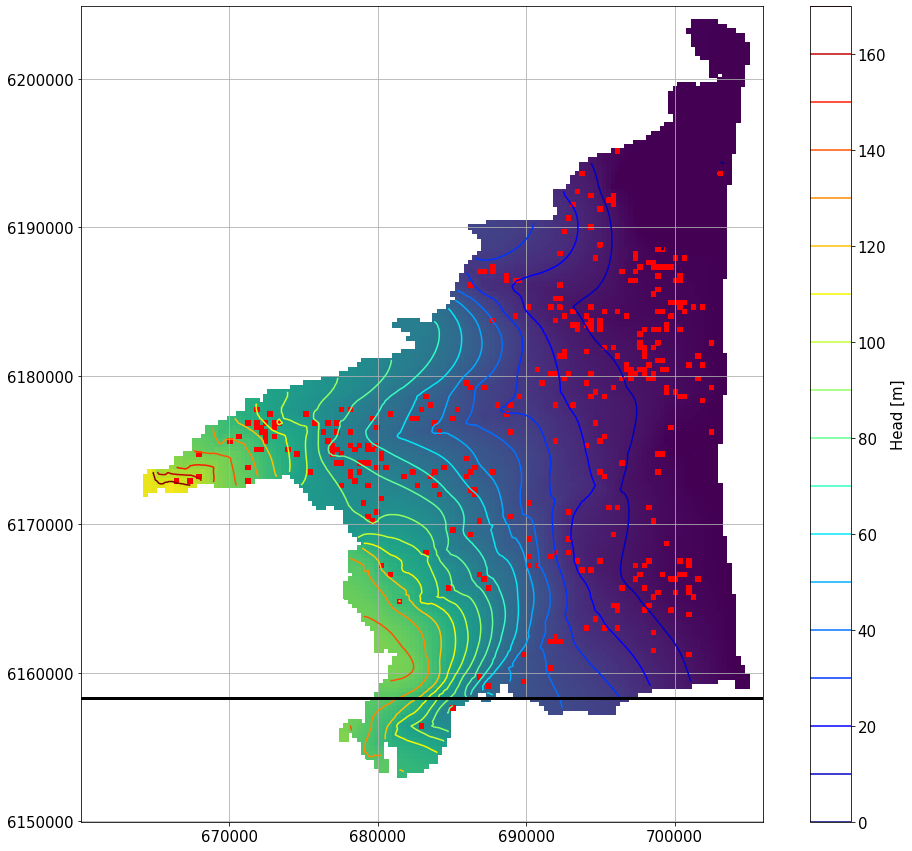

In [29]:
# make a plot

kper = (1,1)
head = hds.get_data(kper)
fig = plt.figure(figsize=(17,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
hmesh.set_clim(0,180)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head,masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
ml.plot_bc("wel") # plot the wells  

# plot Cross-section
row = 155
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)

ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

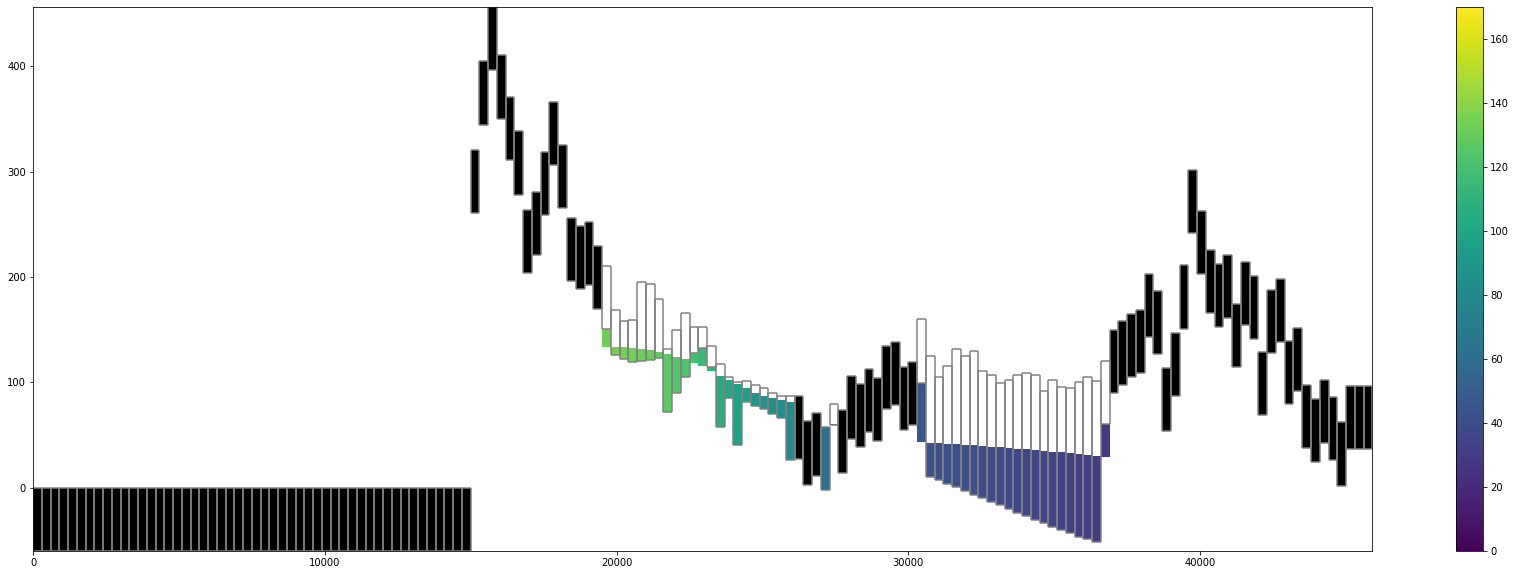

In [30]:
fig,ax = plt.subplots(figsize=(30,10))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()

### export some funny media

In [31]:
import shutil
if os.path.exists('images'):
    shutil.rmtree('images')
os.mkdir('images')

In [39]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('images/Rou_Rou.pdf') as pdfout:
    alltimes = hds.get_times()
    heads = hds.get_alldata()

    for i in range(len(alltimes)):

        head = heads[i,0]

        fig = plt.figure(figsize=(17,15))
        ax  = plt.subplot(1, 1,1, aspect='equal')
        ml = fp.plot.PlotMapView(model=gwf)

        hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
        hmesh.set_clim(0,180)
        #ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
        cont=ml.contour_array(head,masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

        # plot bc
        ml.plot_bc("wel") # plot the wells  

        ax.tick_params(labelsize=15)
        #ax.tick_params(axis="y",direction="in", pad=-120)

        g = plt.colorbar(cont)
        g.set_label("Head [m]",fontsize=15)
        g.ax.tick_params(labelsize=15)

        ax.grid()
        plt.title(np.round(alltimes[i]/86400))
        plt.savefig('images/{0}.png'.format(i))
        plt.close()

In [40]:
#make gif

import imageio
gif_path = 'Rou_Rou.gif'
frames_path = 'images/{i}.png'

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(len(alltimes)):
        writer.append_data(imageio.imread(frames_path.format(i=i)))
        


In [41]:
import imageio_ffmpeg

mp4_path = 'Rou_Rou.mp4'
frames_path = 'images/{i}.png'

with imageio.get_writer(mp4_path, mode='I') as writer:
    for i in range(len(alltimes)):
        writer.append_data(imageio.imread(frames_path.format(i=i)))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1224, 1080) to (1232, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
